# Tutorial from Planetary Computer (PC)

**Parts of the code in this notebook were adopted from Microsofts Planetary Computer website directly.**

[Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook)

## Environment setup

In [1]:
import re
import folium
import rasterio
import numpy as np
import pandas as pd
import pystac_client
from PIL import Image
import geopandas as gpd
import rasterio as rio
from pprint import pprint 
import planetary_computer
from rasterio import warp
from rasterio import features
from pyproj import Transformer
import base64, io, os, requests
import matplotlib.pyplot as plt
from collections import defaultdict
from folium.elements import Element
from rasterio.enums import Resampling
from shapely.geometry import Point, mapping
from shapely.ops import transform as shp_transform
from pystac.extensions.eo import EOExtension as eo
from rasterio import warp, windows, features, enums


plt.style.use("~/geoscience/albedo_downscaling/MNRAS.mplstyle")
%matplotlib inline

## Data access

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [3]:

colls = catalog.get_collections() 
names = [c.id for c in colls] 
pprint([c for c in names if "mcd43" in c.lower() or "modis" in c.lower()])

['modis-64A1-061',
 'modis-17A2H-061',
 'modis-11A2-061',
 'modis-17A2HGF-061',
 'modis-17A3HGF-061',
 'modis-09A1-061',
 'modis-16A3GF-061',
 'modis-21A2-061',
 'modis-43A4-061',
 'modis-09Q1-061',
 'modis-14A1-061',
 'modis-13Q1-061',
 'modis-14A2-061',
 'modis-15A2H-061',
 'modis-11A1-061',
 'modis-15A3H-061',
 'modis-13A1-061',
 'modis-10A2-061',
 'modis-10A1-061']


## Choose a region and time of interest

In [4]:
shapefile_path = "/bsuhome/tnde/scratch/felix/modis/East_River_SHP/ER_bbox.shp"
# AOI from shapefile (WGS84 for STAC)
Boundary = gpd.read_file(shapefile_path)
Boundary_wgs84 = Boundary.to_crs(epsg=4326)

# bounds tuple (minlon, minlat, maxlon, maxlat)
AOI_BOUNDS_LL = tuple(Boundary_wgs84.total_bounds)
AOI_GEOM = mapping(Boundary_wgs84.union_all())
area_of_interest = AOI_GEOM

In [5]:
time_of_interest = "2021-09-01/2023-06-15"

In [6]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 100}},
)

# Check how many granules were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 185 Items


In [7]:
# for item in items:
#     sza = item.properties.get("s2:mean_solar_zenith_angle") or item.properties.get("s2:mean_solar_zenith") \
#               or item.properties.get("eo:sun_zenith") or item.properties.get("sun_zenith") or 35.0
#     print(sza)

In [8]:
names = [c.id for c in colls] 
pprint([c for c in names if "s2" in c.lower() or "sentinel" in c.lower()])

[]


In [9]:
def read_window(asset_href, window):
    with rio.open(asset_href) as ds:
        data = ds.read(window=window, out_dtype="float32")
        transform = ds.window_transform(window)
        crs = ds.crs
        nodata = ds.nodata
    return data, transform, crs, nodata

def reproject_match(src_data, src_transform, src_crs, dst_transform, dst_crs, dst_shape, resampling=Resampling.bilinear):
    dst = np.zeros((src_data.shape[0], dst_shape[0], dst_shape[1]), dtype="float32")
    for i in range(src_data.shape[0]):
        warp.reproject(
            source=src_data[i],
            destination=dst[i],
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=resampling,
            num_threads=2,
        )
    return dst

sample_item = items[0]
with rio.open(sample_item.assets["B11"].href) as ds20:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds20.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(*warped_aoi_bounds, transform=ds20.transform)
    # snap to full pixels
    aoi_window = aoi_window.round_offsets().round_lengths()
    H = aoi_window.height
    W = aoi_window.width
    dst_transform = ds20.window_transform(aoi_window)
    dst_crs = ds20.crs

for item in items:
    # Read AOT asset if available
    aot_href = item.assets.get("AOT").href if "AOT" in item.assets else None
    if aot_href is not None:
        with rio.open(aot_href) as ds_aot:
            win = windows.from_bounds(*warped_aoi_bounds, transform=ds_aot.transform)
            win = win.round_offsets().round_lengths()
            aot_raw, a_tr, a_crs, _ = read_window(aot_href, win)

        # Reproject to target 20 m grid. S2 AOT is 10 m grid by default.
        aot_match = reproject_match(
            aot_raw, a_tr, a_crs,
            dst_transform, dst_crs,
            (H, W),
            resampling=Resampling.bilinear
        )[0]

        # Scale AOT to physical value (Sentinel-2 L2A AOT is typically scaled)
        # Check metadata; scale factor is 0.001:
        # Used because Sentinel-2 L2A AOT is stored as: 
        # stored: 0–3000
        # physical AOT: 0–3
        # scale_factor = 0.001
        aot_scale = 0.001
        aot = aot_match.astype("float32") * aot_scale

        # Mask with validity mask
        # aot = np.where(mask_valid, aot, np.nan)

        # Use a scene-representative AOT (e.g., mean over valid pixels)
        aot_scene = float(np.nanmean(aot))
    else:
        # Fallback if no AOT band: we could use a climatological value
        aot_scene = 0.10  # example
    # print(aot_scene)

In [10]:
for item in items[:1]:
    asset = item.assets["AOT"]          # or "B04", "AOT", etc.
    href = asset.href                   # this is the actual URL/path

    with rasterio.open(href) as src:
        print("dtype:", src.dtypes)
        print("scales:", getattr(src, "scales", None))
        print("offsets:", getattr(src, "offsets", None))

        aot = src.read(1, masked=True)
        print("min/max:", float(aot.min()), float(aot.max()))

dtype: ('uint16',)
scales: (1.0,)
offsets: (0.0,)
min/max: 100.0 185.0


In [11]:
item_list = [item.id for item in items]
print(f"Number of items before removing duplicates: {len(item_list)}")

# Remove the final timestamp (pattern: underscore + 15 digits: 8 for date + 1 'T' + 6 for time)
pattern = re.compile(r'_\d{8}T\d{6}$')

base_names = [pattern.sub("", f) for f in item_list]

# # Keep only unique ones, preserving order
unique_base_names = list(dict.fromkeys(base_names))

print(f"Number of items after removing duplicates: {len(unique_base_names)}")

Number of items before removing duplicates: 185
Number of items after removing duplicates: 128


In [12]:
# unique_base_names

In [13]:
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

Choosing S2A_MSIL2A_20230411T174911_R141_T13SCD_20240827T160002 from 2023-04-11 with 0.0% cloud cover


In [14]:
asset_href = least_cloudy_item.assets["visual"].href

In [15]:
cf_file = "/bsuhome/tnde/scratch/felix/Sentinel-2/s2_albedo_outputs/tsi_cloud_fractions.csv"
cf_vals = pd.read_csv(cf_file)
print(len(cf_vals))
cf_vals = cf_vals[cf_vals["cf_interp"]<=0.10]
display(cf_vals.head())
print(f"Number of items before removing duplicates: {len(cf_vals)}")
cf_vals2 = cf_vals.drop_duplicates(subset=["date"])
print(f"Number of items after removing duplicates: {len(cf_vals2)}")

184


,date,cf_interp,cf_planar
3,2021-09-18,0.068292,0.078906
4,2021-09-23,0.079633,0.081623
13,2021-11-07,0.075779,0.053905
14,2021-11-12,0.064860,0.052515
15,2021-11-17,0.069439,0.053468


Number of items before removing duplicates: 50
Number of items after removing duplicates: 36


In [16]:
# Ensure `items` is a list of STAC Items
# items = list(search.items())  # if needed

def cloud_cover(item):
    cc = eo.ext(item).cloud_cover
    if cc is None:
        cc = item.properties.get("s2:cloud_cover") or item.properties.get("eo:cloud_cover")
    return float('inf') if cc is None else cc

if not items:
    raise ValueError("No items found; adjust date/AOI/cloud filters.")

least_cloudy_item = min(items, key=cloud_cover)
print(least_cloudy_item.id, least_cloudy_item.datetime, cloud_cover(least_cloudy_item))


S2A_MSIL2A_20230411T174911_R141_T13SCD_20240827T160002 2023-04-11 17:49:11.024000+00:00 0.0


In [17]:
top5 = sorted(items, key=cloud_cover)[:5]
# top5

# Export images to html

There are different options but one can just choose only one option depending on their preferences.

## Sentinel-2 gallery

In [18]:
# ---- granule IDs ----
granule_ids = []
base_names_list = []

for day in list(cf_vals["date"]):
    granule_str = [f for f in item_list if day.replace("-", "") in f][0]
    pattern = re.compile(r'_\d{8}T\d{6}$')
    base_name_id = pattern.sub("", granule_str)
    if base_name_id in base_names_list:
        pass
    else:
        base_names_list.append(base_name_id)
        granule_ids.append(granule_str)
    
# print(len(granule_ids), len(base_names_list))
# granule_ids

# # ---- Connect to Planetary Computer STAC ----
# catalog = pystac_client.Client.open(
#     "https://planetarycomputer.microsoft.com/api/stac/v1",
#     modifier=planetary_computer.sign_inplace,
# )

search = catalog.search(collections=["sentinel-2-l2a"], intersects=area_of_interest, ids=granule_ids)
items = list(search.items())
print(f"Found {len(items)} of {len(granule_ids)} requested IDs")
    
# ---- Helper functions ----
def _stretch_01(a, p_low=2, p_high=98):
    """
    Percentile-based contrast stretching to the range [0, 1].

    This function rescales an input numeric array by linearly mapping the values
    between the `p_low` and `p_high` percentiles to [0, 1]. Values below the
    low percentile map to 0, values above the high percentile map to 1, and
    intermediate values are scaled linearly. NaNs and infs are ignored when
    computing percentiles.

    The operation is commonly used to create display-ready images from
    reflectance/ radiance bands or other intensity-like arrays.

    Parameters
    ----------
    a : array_like
        Input numeric array of any shape. Will be converted to ``float32`` for
        processing. NaNs/Infs are allowed; they are ignored in percentile
        computation but remain in the output after clipping.
    p_low : float, optional
        Lower percentile (0–100) used as the black point. Default is 2.
    p_high : float, optional
        Upper percentile (0–100) used as the white point. Default is 98.

    Returns
    -------
    ndarray
        Array of the same shape as `a`, dtype ``float32``, with values in
        ``[0, 1]`` (NaNs remain NaN). If the input contains no finite values,
        returns an array of zeros with the same shape and dtype.

    Notes
    -----
    - If the computed `hi` percentile is less than or equal to the `lo`
      percentile (e.g., near-constant arrays), a small epsilon is added to
      `hi` to avoid division by zero, effectively returning all zeros.
    - Only finite values contribute to percentile estimation; non-finite values
      are left unchanged after the final clipping.
    - This function is symmetric with respect to array shape and can be applied
      to single bands or multi-band stacks (apply per-band if needed).
    """
    a = a.astype("float32")
    m = np.isfinite(a)
    if not m.any():
        return np.zeros_like(a, dtype="float32")
    lo, hi = np.percentile(a[m], [p_low, p_high])
    if hi <= lo: hi = lo + 1e-6
    return np.clip((a - lo) / (hi - lo), 0, 1)

def read_rgb_from_visual_or_bands(item, thumb_px=512):
    """
    Build a small RGB preview image for a Sentinel-2 STAC item.

    Tries assets in this order:
      1) 'rendered_preview' or 'preview' (PNG, fastest; HTTP GET),
      2) 'visual' (TCI GeoTIFF; reads first 3 bands),
      3) raw bands 'B04','B03','B02' (forms RGB, percentile-stretched).
    Falls back to a gray placeholder if all attempts fail. The output image is
    resized in-place to have its longest side ≤ `thumb_px`.

    Parameters
    ----------
    item : pystac.Item
        Sentinel-2 L2A STAC item with assets (must include at least one of the
        tried assets listed above).
    thumb_px : int, default 512
        Maximum thumbnail size (pixels) for the longer edge.

    Returns
    -------
    PIL.Image.Image
        RGB uint8 thumbnail suitable for embedding in HTML or notebooks.
    """
    # rendered_preview (PNG)
    for key in ("rendered_preview", "preview"):
        if key in item.assets:
            try:
                href = item.assets[key].href
                r = requests.get(href, timeout=60)
                r.raise_for_status()
                img = Image.open(io.BytesIO(r.content)).convert("RGB")
                img.thumbnail((thumb_px, thumb_px))
                return img
            except Exception:
                pass

    # visual (TCI GeoTIFF)
    if "visual" in item.assets:
        try:
            href = item.assets["visual"].href
            with rasterio.open(href) as src:
                arr = src.read()  # bands, H, W
            if arr.shape[0] >= 3:
                rgb = np.moveaxis(arr[:3], 0, -1)  # H,W,3
                if rgb.dtype != np.uint8:
                    rgb = (_stretch_01(rgb) * 255).astype("uint8")
                img = Image.fromarray(rgb)
                img.thumbnail((thumb_px, thumb_px))
                return img
        except Exception:
            pass

    # B04/B03/B02
    have = all(k in item.assets for k in ("B04","B03","B02"))
    if have:
        try:
            with rasterio.open(item.assets["B04"].href) as r4, \
                 rasterio.open(item.assets["B03"].href) as r3, \
                 rasterio.open(item.assets["B02"].href) as r2:
                R = r4.read(1); G = r3.read(1); B = r2.read(1)
            rgb = np.dstack([R, G, B])
            rgb = (_stretch_01(rgb) * 255).astype("uint8")
            img = Image.fromarray(rgb)
            img.thumbnail((thumb_px, thumb_px))
            return img
        except Exception:
            pass

    # If everything fails, return a small gray tile noting failure
    img = Image.new("RGB", (thumb_px, thumb_px), (200, 200, 200))
    return img

def to_data_url(pil_img, fmt="PNG"):
    """
    Convert a PIL image into a base64-encoded data URL string.

    This is useful for embedding images directly into HTML without writing them
    to disk. The image is first saved to an in-memory buffer, then base64-encoded
    and returned as a data URL (e.g., "data:image/png;base64,...").

    Parameters
    ----------
    pil_img : PIL.Image.Image
        Input image to encode.
    fmt : str, default "PNG"
        Output image format (e.g., "PNG", "JPEG").

    Returns
    -------
    str
        Base64-encoded data URL string representing the image.
    """
    buf = io.BytesIO()
    pil_img.save(buf, format=fmt)
    b64 = base64.b64encode(buf.getvalue()).decode("ascii")
    return f"data:image/{fmt.lower()};base64,{b64}"

# ---- Build the HTML gallery ----
tiles = []
for it in items:
    try:
        img = read_rgb_from_visual_or_bands(it, thumb_px=512)
        data_url = to_data_url(img, fmt="PNG")
        title = getattr(it, "id", "unknown")
        dt = getattr(it, "datetime", None)
        subtitle = dt.isoformat() if dt else ""
        tiles.append((title, subtitle, data_url))
    except Exception as e:
        tiles.append((getattr(it, "id", "unknown"), "FAILED", ""))
        
html = """
<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<title>Sentinel-2 RGB Gallery</title>
<style>
body{font-family:Arial, sans-serif; margin:20px; background:#111; color:#eee;}
.grid{display:grid; grid-template-columns:repeat(auto-fill, minmax(260px,1fr)); gap:16px;}
.card{background:#1b1b1b; border-radius:12px; overflow:hidden; box-shadow:0 2px 10px rgba(0,0,0,.4);}
.card img{width:100%; display:block;}
.meta{padding:10px 12px;}
.meta h3{margin:0 0 6px; font-size:14px; color:#fff;}
.meta p{margin:0; font-size:12px; color:#ccc; word-break:break-all;}
</style>
</head>
<body>
<h1>Sentinel-2 L2A RGB Gallery</h1>
<div class="grid">
"""

for title, subtitle, data_url in tiles:
    img_tag = f'<img src="{data_url}" alt="{title}">' if data_url else '<div style="height:200px;background:#333;"></div>'
    html += f"""
    <div class="card">
        {img_tag}
        <div class="meta">
            <h3>{title}</h3>
            <p>{subtitle}</p>
        </div>
    </div>
    """

html += """
</div>
</body>
</html>
"""

out_html = "/bsuhome/tnde/geoscience/albedo_downscaling/sentinel_2/webmap_html/s2_valid_10percent_gallery.html"
with open(out_html, "w", encoding="utf-8") as f:
    f.write(html)

print(f"Wrote {out_html} with {len(tiles)} tiles")

Found 36 of 36 requested IDs
Wrote /bsuhome/tnde/geoscience/albedo_downscaling/sentinel_2/webmap_html/s2_valid_10percent_gallery.html with 36 tiles


## Sentinel-2 gallery with cloud cover fraction overlayed

In [19]:
# ---- granule IDs ----
granule_ids = []
base_names_list = []

for day in list(cf_vals["date"]):
    granule_str = [f for f in item_list if day.replace("-", "") in f][0]
    pattern = re.compile(r'_\d{8}T\d{6}$')
    base_name_id = pattern.sub("", granule_str)
    if base_name_id in base_names_list:
        pass
    else:
        base_names_list.append(base_name_id)
        granule_ids.append(granule_str)
    
# print(len(granule_ids), len(base_names_list))
# granule_ids

# # ---- Connect to Planetary Computer STAC ----
# catalog = pystac_client.Client.open(
#     "https://planetarycomputer.microsoft.com/api/stac/v1",
#     modifier=planetary_computer.sign_inplace,
# )

search = catalog.search(collections=["sentinel-2-l2a"], intersects=area_of_interest, ids=granule_ids)
items = list(search.items())
print(f"Found {len(items)} of {len(granule_ids)} requested IDs")

# ---- Helper functions ----
def _stretch_01(a, p_low=2, p_high=98):
    """
    Percentile-based contrast stretching to the range [0, 1].

    This function rescales an input numeric array by linearly mapping the values
    between the `p_low` and `p_high` percentiles to [0, 1]. Values below the
    low percentile map to 0, values above the high percentile map to 1, and
    intermediate values are scaled linearly. NaNs and infs are ignored when
    computing percentiles.

    The operation is commonly used to create display-ready images from
    reflectance/ radiance bands or other intensity-like arrays.

    Parameters
    ----------
    a : array_like
        Input numeric array of any shape. Will be converted to ``float32`` for
        processing. NaNs/Infs are allowed; they are ignored in percentile
        computation but remain in the output after clipping.
    p_low : float, optional
        Lower percentile (0–100) used as the black point. Default is 2.
    p_high : float, optional
        Upper percentile (0–100) used as the white point. Default is 98.

    Returns
    -------
    ndarray
        Array of the same shape as `a`, dtype ``float32``, with values in
        ``[0, 1]`` (NaNs remain NaN). If the input contains no finite values,
        returns an array of zeros with the same shape and dtype.

    Notes
    -----
    - If the computed `hi` percentile is less than or equal to the `lo`
      percentile (e.g., near-constant arrays), a small epsilon is added to
      `hi` to avoid division by zero, effectively returning all zeros.
    - Only finite values contribute to percentile estimation; non-finite values
      are left unchanged after the final clipping.
    - This function is symmetric with respect to array shape and can be applied
      to single bands or multi-band stacks (apply per-band if needed).
    """
    a = a.astype("float32")
    m = np.isfinite(a)
    if not m.any():
        return np.zeros_like(a, dtype="float32")
    lo, hi = np.percentile(a[m], [p_low, p_high])
    if hi <= lo: hi = lo + 1e-6
    return np.clip((a - lo) / (hi - lo), 0, 1)

def _get_cloud_pct(item):
    """Return cloud percentage as float or None from common STAC keys."""
    props = getattr(item, "properties", {}) or {}
    for k in ("eo:cloud_cover", "s2:cloud_percentage", "cloud_cover"):
        if k in props:
            try:
                return float(props[k])
            except Exception:
                pass
    return None

def read_rgb_from_visual_or_bands(item, thumb_px=512):
    """
    Build a small RGB preview image for a Sentinel-2 STAC item.

    Tries assets in this order:
      1) 'rendered_preview' or 'preview' (PNG, fastest; HTTP GET),
      2) 'visual' (TCI GeoTIFF; reads first 3 bands),
      3) raw bands 'B04','B03','B02' (forms RGB, percentile-stretched).
    Falls back to a gray placeholder if all attempts fail. The output image is
    resized in-place to have its longest side ≤ `thumb_px`.

    Parameters
    ----------
    item : pystac.Item
        Sentinel-2 L2A STAC item with assets (must include at least one of the
        tried assets listed above).
    thumb_px : int, default 512
        Maximum thumbnail size (pixels) for the longer edge.

    Returns
    -------
    PIL.Image.Image
        RGB uint8 thumbnail suitable for embedding in HTML or notebooks.
    """
    # rendered_preview (PNG)
    for key in ("rendered_preview", "preview"):
        if key in item.assets:
            try:
                href = item.assets[key].href
                r = requests.get(href, timeout=60)
                r.raise_for_status()
                img = Image.open(io.BytesIO(r.content)).convert("RGB")
                img.thumbnail((thumb_px, thumb_px))
                return img
            except Exception:
                pass

    # visual (TCI GeoTIFF)
    if "visual" in item.assets:
        try:
            href = item.assets["visual"].href
            with rasterio.open(href) as src:
                arr = src.read()  # bands, H, W
            if arr.shape[0] >= 3:
                rgb = np.moveaxis(arr[:3], 0, -1)  # H,W,3
                if rgb.dtype != np.uint8:
                    rgb = (_stretch_01(rgb) * 255).astype("uint8")
                img = Image.fromarray(rgb)
                img.thumbnail((thumb_px, thumb_px))
                return img
        except Exception:
            pass

    # B04/B03/B02
    have = all(k in item.assets for k in ("B04","B03","B02"))
    if have:
        try:
            with rasterio.open(item.assets["B04"].href) as r4, \
                 rasterio.open(item.assets["B03"].href) as r3, \
                 rasterio.open(item.assets["B02"].href) as r2:
                R = r4.read(1); G = r3.read(1); B = r2.read(1)
            rgb = np.dstack([R, G, B])
            rgb = (_stretch_01(rgb) * 255).astype("uint8")
            img = Image.fromarray(rgb)
            img.thumbnail((thumb_px, thumb_px))
            return img
        except Exception:
            pass

    # If everything fails, return a small gray tile noting failure
    img = Image.new("RGB", (thumb_px, thumb_px), (200, 200, 200))
    return img

def to_data_url(pil_img, fmt="PNG"):
    """
    Convert a PIL image into a base64-encoded data URL string.

    This is useful for embedding images directly into HTML without writing them
    to disk. The image is first saved to an in-memory buffer, then base64-encoded
    and returned as a data URL (e.g., "data:image/png;base64,...").

    Parameters
    ----------
    pil_img : PIL.Image.Image
        Input image to encode.
    fmt : str, default "PNG"
        Output image format (e.g., "PNG", "JPEG").

    Returns
    -------
    str
        Base64-encoded data URL string representing the image.
    """
    buf = io.BytesIO()
    pil_img.save(buf, format=fmt)
    b64 = base64.b64encode(buf.getvalue()).decode("ascii")
    return f"data:image/{fmt.lower()};base64,{b64}"

# ---- Build the HTML gallery ----
tiles = []
for it in items:
    try:
        img = read_rgb_from_visual_or_bands(it, thumb_px=512)
        data_url = to_data_url(img, fmt="PNG")
        title = getattr(it, "id", "unknown")
        dt = getattr(it, "datetime", None)
        subtitle = dt.isoformat() if dt else ""
        cloud = _get_cloud_pct(it)
        cloud_str = (f"{cloud:.1f}%") if (cloud is not None) else "N/A"
        tiles.append((title, subtitle, data_url, cloud_str))   # <<-- ADDED cloud_str
    except Exception as e:
        tiles.append((getattr(it, "id", "unknown"), "FAILED", "", "N/A"))
        
html = """
<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<title>Sentinel-2 RGB Gallery</title>
<style>
body{font-family:Arial, sans-serif; margin:20px; background:#111; color:#eee;}
.grid{display:grid; grid-template-columns:repeat(auto-fill, minmax(260px,1fr)); gap:16px;}
.card{background:#1b1b1b; border-radius:12px; overflow:hidden; box-shadow:0 2px 10px rgba(0,0,0,.4); position:relative;} /* << ADDED position */
.card img{width:100%; display:block;}
.meta{padding:10px 12px;}
.meta h3{margin:0 0 6px; font-size:14px; color:#fff;}
.meta p{margin:0; font-size:12px; color:#ccc; word-break:break-all;}
.cloud{position:absolute; top:8px; left:8px; background:rgba(0,0,0,0.35); color:#ff0000; padding:2px 6px; border-radius:6px; font-size:15px; font-weight:700;} /* << NEW */
</style>
</head>
<body>
<h1>Sentinel-2 L2A RGB Gallery</h1>
<div class="grid">
"""

for title, subtitle, data_url, cloud_str in tiles:   # <<-- unpack cloud_str
    img_tag = f'<img src="{data_url}" alt="{title}">' if data_url else '<div style="height:200px;background:#333;"></div>'
    html += f"""
    <div class="card">
        <div class="cloud">Cloud: {cloud_str}</div>  <!-- <<-- ADDED overlay label -->
        {img_tag}
        <div class="meta">
            <h3>{title}</h3>
            <p>{subtitle}</p>
        </div>
    </div>
    """
html += """
</div>
</body>
</html>
"""

out_html = "/bsuhome/tnde/geoscience/albedo_downscaling/sentinel_2/webmap_html/s2_valid_10percent_gallery2.html"
with open(out_html, "w", encoding="utf-8") as f:
    f.write(html)

print(f"Wrote {out_html} with {len(tiles)} tiles")

Found 36 of 36 requested IDs
Wrote /bsuhome/tnde/geoscience/albedo_downscaling/sentinel_2/webmap_html/s2_valid_10percent_gallery2.html with 36 tiles


## Sentinel-2 gallery with date dropdown

In [20]:
# ---- granule IDs ----
granule_ids = []
base_names_list = []

for day in list(cf_vals["date"]):
    granule_str = [f for f in item_list if day.replace("-", "") in f][0]
    pattern = re.compile(r'_\d{8}T\d{6}$')
    base_name_id = pattern.sub("", granule_str)
    if base_name_id in base_names_list:
        pass
    else:
        base_names_list.append(base_name_id)
        granule_ids.append(granule_str)
    
# print(len(granule_ids), len(base_names_list))
# # ---- Connect to Planetary Computer STAC ----
# catalog = pystac_client.Client.open(
#     "https://planetarycomputer.microsoft.com/api/stac/v1",
#     modifier=planetary_computer.sign_inplace,
# )

search = catalog.search(collections=["sentinel-2-l2a"], intersects=area_of_interest, ids=granule_ids)
items = list(search.items())
print(f"Found {len(granule_ids)} of {len(granule_ids)} requested IDs")
items = [planetary_computer.sign(it) for it in items]

# ---- Helper functions ----
def _stretch_01(a, p_low=2, p_high=98):
    """
    Percentile-based contrast stretching to the range [0, 1].

    This function rescales an input numeric array by linearly mapping the values
    between the `p_low` and `p_high` percentiles to [0, 1]. Values below the
    low percentile map to 0, values above the high percentile map to 1, and
    intermediate values are scaled linearly. NaNs and infs are ignored when
    computing percentiles.

    The operation is commonly used to create display-ready images from
    reflectance/ radiance bands or other intensity-like arrays.

    Parameters
    ----------
    a : array_like
        Input numeric array of any shape. Will be converted to ``float32`` for
        processing. NaNs/Infs are allowed; they are ignored in percentile
        computation but remain in the output after clipping.
    p_low : float, optional
        Lower percentile (0–100) used as the black point. Default is 2.
    p_high : float, optional
        Upper percentile (0–100) used as the white point. Default is 98.

    Returns
    -------
    ndarray
        Array of the same shape as `a`, dtype ``float32``, with values in
        ``[0, 1]`` (NaNs remain NaN). If the input contains no finite values,
        returns an array of zeros with the same shape and dtype.

    Notes
    -----
    - If the computed `hi` percentile is less than or equal to the `lo`
      percentile (e.g., near-constant arrays), a small epsilon is added to
      `hi` to avoid division by zero, effectively returning all zeros.
    - Only finite values contribute to percentile estimation; non-finite values
      are left unchanged after the final clipping.
    - This function is symmetric with respect to array shape and can be applied
      to single bands or multi-band stacks (apply per-band if needed).
    """
    a = a.astype("float32")
    m = np.isfinite(a)
    if not m.any():
        return np.zeros_like(a, dtype="float32")
    lo, hi = np.percentile(a[m], [p_low, p_high])
    if hi <= lo: hi = lo + 1e-6
    return np.clip((a - lo) / (hi - lo), 0, 1)

def read_rgb_from_visual_or_bands(item, thumb_px=512):
    """
    Build a small RGB preview image for a Sentinel-2 STAC item.

    Tries assets in this order:
      1) 'rendered_preview' or 'preview' (PNG, fastest; HTTP GET),
      2) 'visual' (TCI GeoTIFF; reads first 3 bands),
      3) raw bands 'B04','B03','B02' (forms RGB, percentile-stretched).
    Falls back to a gray placeholder if all attempts fail. The output image is
    resized in-place to have its longest side ≤ `thumb_px`.

    Parameters
    ----------
    item : pystac.Item
        Sentinel-2 L2A STAC item with assets (must include at least one of the
        tried assets listed above).
    thumb_px : int, default 512
        Maximum thumbnail size (pixels) for the longer edge.

    Returns
    -------
    PIL.Image.Image
        RGB uint8 thumbnail suitable for embedding in HTML or notebooks.
    """
    # rendered_preview (PNG)
    for key in ("rendered_preview", "preview"):
        if key in item.assets:
            try:
                href = item.assets[key].href
                r = requests.get(href, timeout=60)
                r.raise_for_status()
                img = Image.open(io.BytesIO(r.content)).convert("RGB")
                img.thumbnail((thumb_px, thumb_px))
                return img
            except Exception:
                pass

    # visual (TCI GeoTIFF)
    if "visual" in item.assets:
        try:
            href = item.assets["visual"].href
            with rasterio.open(href) as src:
                arr = src.read()  # bands, H, W
            if arr.shape[0] >= 3:
                rgb = np.moveaxis(arr[:3], 0, -1)  # H,W,3
                if rgb.dtype != np.uint8:
                    rgb = (_stretch_01(rgb) * 255).astype("uint8")
                img = Image.fromarray(rgb)
                img.thumbnail((thumb_px, thumb_px))
                return img
        except Exception:
            pass

    # B04/B03/B02
    have = all(k in item.assets for k in ("B04","B03","B02"))
    if have:
        try:
            with rasterio.open(item.assets["B04"].href) as r4, \
                 rasterio.open(item.assets["B03"].href) as r3, \
                 rasterio.open(item.assets["B02"].href) as r2:
                R = r4.read(1); G = r3.read(1); B = r2.read(1)
            rgb = np.dstack([R, G, B])
            rgb = (_stretch_01(rgb) * 255).astype("uint8")
            img = Image.fromarray(rgb)
            img.thumbnail((thumb_px, thumb_px))
            return img
        except Exception:
            pass

    # If everything fails, return a small gray tile noting failure
    img = Image.new("RGB", (thumb_px, thumb_px), (200, 200, 200))
    return img

def to_data_url(pil_img, fmt="PNG"):
    """
    Convert a PIL image into a base64-encoded data URL string.

    This is useful for embedding images directly into HTML without writing them
    to disk. The image is first saved to an in-memory buffer, then base64-encoded
    and returned as a data URL (e.g., "data:image/png;base64,...").

    Parameters
    ----------
    pil_img : PIL.Image.Image
        Input image to encode.
    fmt : str, default "PNG"
        Output image format (e.g., "PNG", "JPEG").

    Returns
    -------
    str
        Base64-encoded data URL string representing the image.
    """
    buf = io.BytesIO()
    pil_img.save(buf, format=fmt)
    b64 = base64.b64encode(buf.getvalue()).decode("ascii")
    return f"data:image/{fmt.lower()};base64,{b64}"

# ---- Build a Folium map with a DATE DROPDOWN + terrain basemap (zoomable) ----
# Compute overall bounds to fit map view
def _bbox_to_bounds(bbox):
    """
    Convert a bounding box from [minx, miny, maxx, maxy] format to
    Folium/Leaflet bounds format [[south, west], [north, east]].

    Parameters
    ----------
    bbox : list or tuple of float
        Bounding box coordinates in the order [minx, miny, maxx, maxy].

    Returns
    -------
    list
        Nested list of [[south, west], [north, east]] suitable for Folium bounds.
    """
    return [[bbox[1], bbox[0]], [bbox[3], bbox[2]]]

# Group items by UTC date (YYYY-MM-DD)
by_date = defaultdict(list)
for it in items:
    dt = getattr(it, "datetime", None)
    date_str = dt.date().isoformat() if dt else "unknown"
    by_date[date_str].append(it)

if not items:
    raise SystemExit("No items to display on a map.")

# Initialize map centered on first item's bbox, use TERRAIN basemap
first_bbox = items[0].bbox or getattr(items[0], "bbox", None)
if not first_bbox:
    m = folium.Map(location=[0, 0], zoom_start=4, tiles=None)
    # folium.TileLayer(
    #     tiles="https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png",
    #     name="Terrain (OpenTopoMap)",
    #     attr="Map data © OpenStreetMap contributors, SRTM | Map style © OpenTopoMap (CC-BY-SA)",
    #     max_zoom=17,
    #     control=False
    # ).add_to(m)
    
    # # Esri topo style
    # folium.TileLayer(
    #     tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}",
    #     name="Esri WorldTopoMap",
    #     attr="Tiles © Esri — Esri, DeLorme, FAO, NOAA, USGS, © OpenStreetMap contributors, and the GIS User Community",
    #     max_zoom=19,
    #     control=False
    # ).add_to(m)
    
    # Esri world imagery
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        name="Esri World Imagery",
        attr="Tiles © Esri — Source: Esri, Maxar, Earthstar Geographics, and the GIS User Community",
        max_zoom=19,
        control=False
    ).add_to(m)
else:
    (minx, miny, maxx, maxy) = first_bbox
    ctr_lat = (miny + maxy) / 2
    ctr_lon = (minx + maxx) / 2
    m = folium.Map(location=[ctr_lat, ctr_lon], zoom_start=9, tiles=None)
    # folium.TileLayer(
    #     tiles="https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png",
    #     name="Terrain (OpenTopoMap)",
    #     attr="Map data © OpenStreetMap contributors, SRTM | Map style © OpenTopoMap (CC-BY-SA)",
    #     max_zoom=17,
    #     control=False
    # ).add_to(m)
    
    # # Esri topo style
    # folium.TileLayer(
    #     tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}",
    #     name="Esri WorldTopoMap",
    #     attr="Tiles © Esri — Esri, DeLorme, FAO, NOAA, USGS, © OpenStreetMap contributors, and the GIS User Community",
    #     max_zoom=19,
    #     control=False
    # ).add_to(m)
    
    # Esri world imagery
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        name="Esri World Imagery",
        attr="Tiles © Esri — Source: Esri, Maxar, Earthstar Geographics, and the GIS User Community",
        max_zoom=19,
        control=False
    ).add_to(m)

# Build a FeatureGroup per date; only the FIRST date is visible by default
dates_sorted = sorted(by_date.keys())
all_bounds = []
date_groups = {}  # keep for JS wiring if needed

for i, d in enumerate(dates_sorted, 1):
    fg = folium.FeatureGroup(name=d, show=(i == 1))
    date_groups[d] = fg

    for it in by_date[d]:
        bbox = it.bbox
        if bbox:
            all_bounds.append(_bbox_to_bounds(bbox))

        # Prefer Planetary Computer tilejson (zoomable)
        if "tilejson" not in it.assets:
            continue
        try:
            tj_href = it.assets["tilejson"].href
            tj = requests.get(tj_href, timeout=60).json()
            tiles_url = tj["tiles"][0]
        except Exception:
            continue

        folium.TileLayer(
            tiles=tiles_url,
            name=getattr(it, "id", "granule"),
            attr="Microsoft Planetary Computer / Sentinel-2",
            overlay=True,
            control=False,       # control at the DATE group level, not per-granule
            show=True,           # shown if its FeatureGroup is shown
            max_zoom=14,
            min_zoom=2
        ).add_to(fg)

        # outline footprint
        if bbox:
            folium.Rectangle(
                bounds=_bbox_to_bounds(bbox),
                color="#ff7800",
                weight=1,
                fill=False,
                tooltip=f"{getattr(it,'id','')}"
            ).add_to(fg)

    fg.add_to(m)

# Layer control (shows date groups)
folium.LayerControl(collapsed=False).add_to(m)

# Fit to all bounds if available
if all_bounds:
    min_lat = min(b[0][0] for b in all_bounds)
    min_lon = min(b[0][1] for b in all_bounds)
    max_lat = max(b[1][0] for b in all_bounds)
    max_lon = max(b[1][1] for b in all_bounds)
    m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

# ---------- Add a fixed-position DATE DROPDOWN that filters FeatureGroups ----------
# First date selected by default
options_html = "\n".join(
    [f'<option value="{d}"{" selected" if i==0 else ""}>{d}</option>' for i, d in enumerate(dates_sorted)]
)

control_html = f"""
<div id="date-dropdown" style="
  position: absolute; top: 10px; left: 46px; z-index: 9999;
  background: rgba(255,255,255,0.95); padding: 6px 8px; border-radius: 6px;
  box-shadow: 0 1px 4px rgba(0,0,0,0.3); font-family: Arial; font-size: 13px;">
  <label for="dateSelect" style="margin-right:6px;">Date</label>
  <select id="dateSelect">{options_html}</select>
</div>
<script>
(function() {{
  const sel = document.getElementById('dateSelect');

  // Find overlay checkboxes in Leaflet layer control whose label text equals the date
  function getOverlayRows() {{
    return Array.from(document.querySelectorAll('.leaflet-control-layers-overlays label'));
  }}

  function setDate(d) {{
    const rows = getOverlayRows();
    // Uncheck all
    rows.forEach(row => {{
      const cb = row.querySelector('input[type="checkbox"]');
      if (cb && cb.checked) cb.click();
    }});
    // Check only the row whose label text equals the selected date
    rows.forEach(row => {{
      const txt = row.textContent.trim();
      const cb = row.querySelector('input[type="checkbox"]');
      if (txt === d && cb && !cb.checked) cb.click();
    }});
  }}

  sel.addEventListener('change', () => setDate(sel.value));

  // Apply default (first option) on load
  setTimeout(() => setDate(sel.value), 200);
}})();
</script>
"""

m.get_root().html.add_child(Element(control_html))
out_html = "/bsuhome/tnde/geoscience/albedo_downscaling/sentinel_2/webmap_html/s2_date_dropdown_valid_10percent_gallery_terrain_esri_world.html"
m.save(out_html)
print(f"Wrote interactive Folium map with date dropdown + terrain basemap: {out_html}")

Found 36 of 36 requested IDs
Wrote interactive Folium map with date dropdown + terrain basemap: /bsuhome/tnde/geoscience/albedo_downscaling/sentinel_2/webmap_html/s2_date_dropdown_valid_10percent_gallery_terrain_esri_world.html


## Sentinel-2 gallery with date dropdown and cloud cover fraction overlayed

In [21]:
# ---- granule IDs ----
granule_ids = []
base_names_list = []

for day in list(cf_vals["date"]):
    granule_str = [f for f in item_list if day.replace("-", "") in f][0]
    pattern = re.compile(r'_\d{8}T\d{6}$')
    base_name_id = pattern.sub("", granule_str)
    if base_name_id in base_names_list:
        pass
    else:
        base_names_list.append(base_name_id)
        granule_ids.append(granule_str)
    
# print(len(granule_ids), len(base_names_list))
# # ---- Connect to Planetary Computer STAC ----
# catalog = pystac_client.Client.open(
#     "https://planetarycomputer.microsoft.com/api/stac/v1",
#     modifier=planetary_computer.sign_inplace,
# )

search = catalog.search(collections=["sentinel-2-l2a"], intersects=area_of_interest, ids=granule_ids)
items = list(search.items())
print(f"Found {len(granule_ids)} of {len(granule_ids)} requested IDs")
items = [planetary_computer.sign(it) for it in items]

# ---- Helper functions ----
def _stretch_01(a, p_low=2, p_high=98):
    """
    Percentile-based contrast stretching to the range [0, 1].

    This function rescales an input numeric array by linearly mapping the values
    between the `p_low` and `p_high` percentiles to [0, 1]. Values below the
    low percentile map to 0, values above the high percentile map to 1, and
    intermediate values are scaled linearly. NaNs and infs are ignored when
    computing percentiles.

    The operation is commonly used to create display-ready images from
    reflectance/ radiance bands or other intensity-like arrays.

    Parameters
    ----------
    a : array_like
        Input numeric array of any shape. Will be converted to ``float32`` for
        processing. NaNs/Infs are allowed; they are ignored in percentile
        computation but remain in the output after clipping.
    p_low : float, optional
        Lower percentile (0–100) used as the black point. Default is 2.
    p_high : float, optional
        Upper percentile (0–100) used as the white point. Default is 98.

    Returns
    -------
    ndarray
        Array of the same shape as `a`, dtype ``float32``, with values in
        ``[0, 1]`` (NaNs remain NaN). If the input contains no finite values,
        returns an array of zeros with the same shape and dtype.

    Notes
    -----
    - If the computed `hi` percentile is less than or equal to the `lo`
      percentile (e.g., near-constant arrays), a small epsilon is added to
      `hi` to avoid division by zero, effectively returning all zeros.
    - Only finite values contribute to percentile estimation; non-finite values
      are left unchanged after the final clipping.
    - This function is symmetric with respect to array shape and can be applied
      to single bands or multi-band stacks (apply per-band if needed).
    """
    a = a.astype("float32")
    m = np.isfinite(a)
    if not m.any():
        return np.zeros_like(a, dtype="float32")
    lo, hi = np.percentile(a[m], [p_low, p_high])
    if hi <= lo: hi = lo + 1e-6
    return np.clip((a - lo) / (hi - lo), 0, 1)

def _get_cloud_pct(item):
    """Return cloud percentage as float or None from common STAC keys."""
    props = getattr(item, "properties", {}) or {}
    for k in ("eo:cloud_cover", "s2:cloud_percentage", "cloud_cover"):
        if k in props:
            try:
                return float(props[k])
            except Exception:
                pass
    return None

def read_rgb_from_visual_or_bands(item, thumb_px=512):
    """
    Build a small RGB preview image for a Sentinel-2 STAC item.

    Tries assets in this order:
      1) 'rendered_preview' or 'preview' (PNG, fastest; HTTP GET),
      2) 'visual' (TCI GeoTIFF; reads first 3 bands),
      3) raw bands 'B04','B03','B02' (forms RGB, percentile-stretched).
    Falls back to a gray placeholder if all attempts fail. The output image is
    resized in-place to have its longest side ≤ `thumb_px`.

    Parameters
    ----------
    item : pystac.Item
        Sentinel-2 L2A STAC item with assets (must include at least one of the
        tried assets listed above).
    thumb_px : int, default 512
        Maximum thumbnail size (pixels) for the longer edge.

    Returns
    -------
    PIL.Image.Image
        RGB uint8 thumbnail suitable for embedding in HTML or notebooks.
    """
    # rendered_preview (PNG)
    for key in ("rendered_preview", "preview"):
        if key in item.assets:
            try:
                href = item.assets[key].href
                r = requests.get(href, timeout=60)
                r.raise_for_status()
                img = Image.open(io.BytesIO(r.content)).convert("RGB")
                img.thumbnail((thumb_px, thumb_px))
                return img
            except Exception:
                pass

    # visual (TCI GeoTIFF)
    if "visual" in item.assets:
        try:
            href = item.assets["visual"].href
            with rasterio.open(href) as src:
                arr = src.read()  # bands, H, W
            if arr.shape[0] >= 3:
                rgb = np.moveaxis(arr[:3], 0, -1)  # H,W,3
                if rgb.dtype != np.uint8:
                    rgb = (_stretch_01(rgb) * 255).astype("uint8")
                img = Image.fromarray(rgb)
                img.thumbnail((thumb_px, thumb_px))
                return img
        except Exception:
            pass

    # B04/B03/B02
    have = all(k in item.assets for k in ("B04","B03","B02"))
    if have:
        try:
            with rasterio.open(item.assets["B04"].href) as r4, \
                 rasterio.open(item.assets["B03"].href) as r3, \
                 rasterio.open(item.assets["B02"].href) as r2:
                R = r4.read(1); G = r3.read(1); B = r2.read(1)
            rgb = np.dstack([R, G, B])
            rgb = (_stretch_01(rgb) * 255).astype("uint8")
            img = Image.fromarray(rgb)
            img.thumbnail((thumb_px, thumb_px))
            return img
        except Exception:
            pass

    # If everything fails, return a small gray tile noting failure
    img = Image.new("RGB", (thumb_px, thumb_px), (200, 200, 200))
    return img

def to_data_url(pil_img, fmt="PNG"):
    """
    Convert a PIL image into a base64-encoded data URL string.

    This is useful for embedding images directly into HTML without writing them
    to disk. The image is first saved to an in-memory buffer, then base64-encoded
    and returned as a data URL (e.g., "data:image/png;base64,...").

    Parameters
    ----------
    pil_img : PIL.Image.Image
        Input image to encode.
    fmt : str, default "PNG"
        Output image format (e.g., "PNG", "JPEG").

    Returns
    -------
    str
        Base64-encoded data URL string representing the image.
    """
    buf = io.BytesIO()
    pil_img.save(buf, format=fmt)
    b64 = base64.b64encode(buf.getvalue()).decode("ascii")
    return f"data:image/{fmt.lower()};base64,{b64}"

# ---- Build a Folium map with a DATE DROPDOWN + terrain basemap (zoomable) ----
# Compute overall bounds to fit map view
def _bbox_to_bounds(bbox):
    """
    Convert a bounding box from [minx, miny, maxx, maxy] format to
    Folium/Leaflet bounds format [[south, west], [north, east]].

    Parameters
    ----------
    bbox : list or tuple of float
        Bounding box coordinates in the order [minx, miny, maxx, maxy].

    Returns
    -------
    list
        Nested list of [[south, west], [north, east]] suitable for Folium bounds.
    """
    return [[bbox[1], bbox[0]], [bbox[3], bbox[2]]]

# Group items by UTC date (YYYY-MM-DD)
by_date = defaultdict(list)
for it in items:
    dt = getattr(it, "datetime", None)
    date_str = dt.date().isoformat() if dt else "unknown"
    by_date[date_str].append(it)

if not items:
    raise SystemExit("No items to display on a map.")

# Initialize map centered on first item's bbox, use TERRAIN basemap
first_bbox = items[0].bbox or getattr(items[0], "bbox", None)
if not first_bbox:
    m = folium.Map(location=[0, 0], zoom_start=4, tiles=None)
    # folium.TileLayer(
    #     tiles="https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png",
    #     name="Terrain (OpenTopoMap)",
    #     attr="Map data © OpenStreetMap contributors, SRTM | Map style © OpenTopoMap (CC-BY-SA)",
    #     max_zoom=17,
    #     control=False
    # ).add_to(m)
    
    # # Esri topo style
    # folium.TileLayer(
    #     tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}",
    #     name="Esri WorldTopoMap",
    #     attr="Tiles © Esri — Esri, DeLorme, FAO, NOAA, USGS, © OpenStreetMap contributors, and the GIS User Community",
    #     max_zoom=19,
    #     control=False
    # ).add_to(m)
    
    # Esri world imagery
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        name="Esri World Imagery",
        attr="Tiles © Esri — Source: Esri, Maxar, Earthstar Geographics, and the GIS User Community",
        max_zoom=19,
        control=False
    ).add_to(m)
else:
    (minx, miny, maxx, maxy) = first_bbox
    ctr_lat = (miny + maxy) / 2
    ctr_lon = (minx + maxx) / 2
    m = folium.Map(location=[ctr_lat, ctr_lon], zoom_start=9, tiles=None)
    # folium.TileLayer(
    #     tiles="https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png",
    #     name="Terrain (OpenTopoMap)",
    #     attr="Map data © OpenStreetMap contributors, SRTM | Map style © OpenTopoMap (CC-BY-SA)",
    #     max_zoom=17,
    #     control=False
    # ).add_to(m)
    
    # # Esri topo style
    # folium.TileLayer(
    #     tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}",
    #     name="Esri WorldTopoMap",
    #     attr="Tiles © Esri — Esri, DeLorme, FAO, NOAA, USGS, © OpenStreetMap contributors, and the GIS User Community",
    #     max_zoom=19,
    #     control=False
    # ).add_to(m)
    
    # Esri world imagery
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        name="Esri World Imagery",
        attr="Tiles © Esri — Source: Esri, Maxar, Earthstar Geographics, and the GIS User Community",
        max_zoom=19,
        control=False
    ).add_to(m)

# Build a FeatureGroup per date; only the FIRST date is visible by default
dates_sorted = sorted(by_date.keys())
all_bounds = []
date_groups = {}  # keep for JS wiring if needed

for i, d in enumerate(dates_sorted, 1):
    fg = folium.FeatureGroup(name=d, show=(i == 1))
    date_groups[d] = fg

    for it in by_date[d]:
        bbox = it.bbox
        if bbox:
            all_bounds.append(_bbox_to_bounds(bbox))

        # Prefer Planetary Computer tilejson (zoomable)
        if "tilejson" not in it.assets:
            continue
        try:
            tj_href = it.assets["tilejson"].href
            tj = requests.get(tj_href, timeout=60).json()
            tiles_url = tj["tiles"][0]
        except Exception:
            continue

        folium.TileLayer(
            tiles=tiles_url,
            name=getattr(it, "id", "granule"),
            attr="Microsoft Planetary Computer / Sentinel-2",
            overlay=True,
            control=False,
            show=True,
            max_zoom=14,
            min_zoom=2
        ).add_to(fg)

        # outline footprint
        if bbox:
            # Draw the footprint rectangle
            folium.Rectangle(
                bounds=_bbox_to_bounds(bbox),
                color="#ff7800",
                weight=1,
                fill=False,
                tooltip=f"{getattr(it,'id','')}"
            ).add_to(fg)

            # --- NEW: add a red cloud-cover label at top-left (NW) corner ---
            minx, miny, maxx, maxy = bbox
            # nw_lat, nw_lon = maxy, minx  # (lat, lon) for NW corner
            # (lat, lon) for NW corner
            nw_lat = maxy - 0.02 * (maxy - miny)
            nw_lon = minx + 0.02 * (maxx - minx)
            cloud = _get_cloud_pct(it)
            cloud_str = (f"{cloud:.1f}%") if (cloud is not None) else "N/A"

            folium.Marker(
                location=[nw_lat, nw_lon],
                icon=folium.DivIcon(html=f'''
                    <div style="
                        background: rgba(255,255,255,0.45); 
                        border-radius: 6px; 
                        padding: 2px 6px; 
                        border: 1px solid #c00; 
                        color: #ff0000; 
                        font-weight: 700; 
                        font-size: 15px; 
                        white-space: nowrap; 
                        display: inline-block;">
                        Cloud: {cloud_str}
                    </div>
                ''')
            ).add_to(fg)

    fg.add_to(m)

# Layer control (shows date groups)
folium.LayerControl(collapsed=False).add_to(m)

# Fit to all bounds if available
if all_bounds:
    min_lat = min(b[0][0] for b in all_bounds)
    min_lon = min(b[0][1] for b in all_bounds)
    max_lat = max(b[1][0] for b in all_bounds)
    max_lon = max(b[1][1] for b in all_bounds)
    m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

# ---------- Add a fixed-position DATE DROPDOWN that filters FeatureGroups ----------
# First date selected by default
options_html = "\n".join(
    [f'<option value="{d}"{" selected" if i==0 else ""}>{d}</option>' for i, d in enumerate(dates_sorted)]
)

control_html = f"""
<div id="date-dropdown" style="
  position: absolute; top: 10px; left: 46px; z-index: 9999;
  background: rgba(255,255,255,0.95); padding: 6px 8px; border-radius: 6px;
  box-shadow: 0 1px 4px rgba(0,0,0,0.3); font-family: Arial; font-size: 13px;">
  <label for="dateSelect" style="margin-right:6px;">Date</label>
  <select id="dateSelect">{options_html}</select>
</div>
<script>
(function() {{
  const sel = document.getElementById('dateSelect');

  // Find overlay checkboxes in Leaflet layer control whose label text equals the date
  function getOverlayRows() {{
    return Array.from(document.querySelectorAll('.leaflet-control-layers-overlays label'));
  }}

  function setDate(d) {{
    const rows = getOverlayRows();
    // Uncheck all
    rows.forEach(row => {{
      const cb = row.querySelector('input[type="checkbox"]');
      if (cb && cb.checked) cb.click();
    }});
    // Check only the row whose label text equals the selected date
    rows.forEach(row => {{
      const txt = row.textContent.trim();
      const cb = row.querySelector('input[type="checkbox"]');
      if (txt === d && cb && !cb.checked) cb.click();
    }});
  }}

  sel.addEventListener('change', () => setDate(sel.value));

  // Apply default (first option) on load
  setTimeout(() => setDate(sel.value), 200);
}})();
</script>
"""

m.get_root().html.add_child(Element(control_html))
out_html = "/bsuhome/tnde/geoscience/albedo_downscaling/sentinel_2/webmap_html/s2_date_dropdown_valid_10percent_gallery_terrain_esri_world2.html"
m.save(out_html)
print(f"Wrote interactive Folium map with date dropdown + terrain basemap: {out_html}")

Found 36 of 36 requested IDs
Wrote interactive Folium map with date dropdown + terrain basemap: /bsuhome/tnde/geoscience/albedo_downscaling/sentinel_2/webmap_html/s2_date_dropdown_valid_10percent_gallery_terrain_esri_world2.html


## Draw a circle of radius 3.5 km around the center of our region of interest

We want to compute the cloud cover fractions for each image with the $3.5~km$ radius circle and compare the results later on to that of the TSI Sky-Cover time series data.

This cell is not part of the original code adopted from the Planetary Computer website.

Circle center (lon, lat): (-106.977938, 38.974302)
Cloud cover inside 3.5 km circle: 0.000%  (cloud pixels 0 / valid pixels 96054)


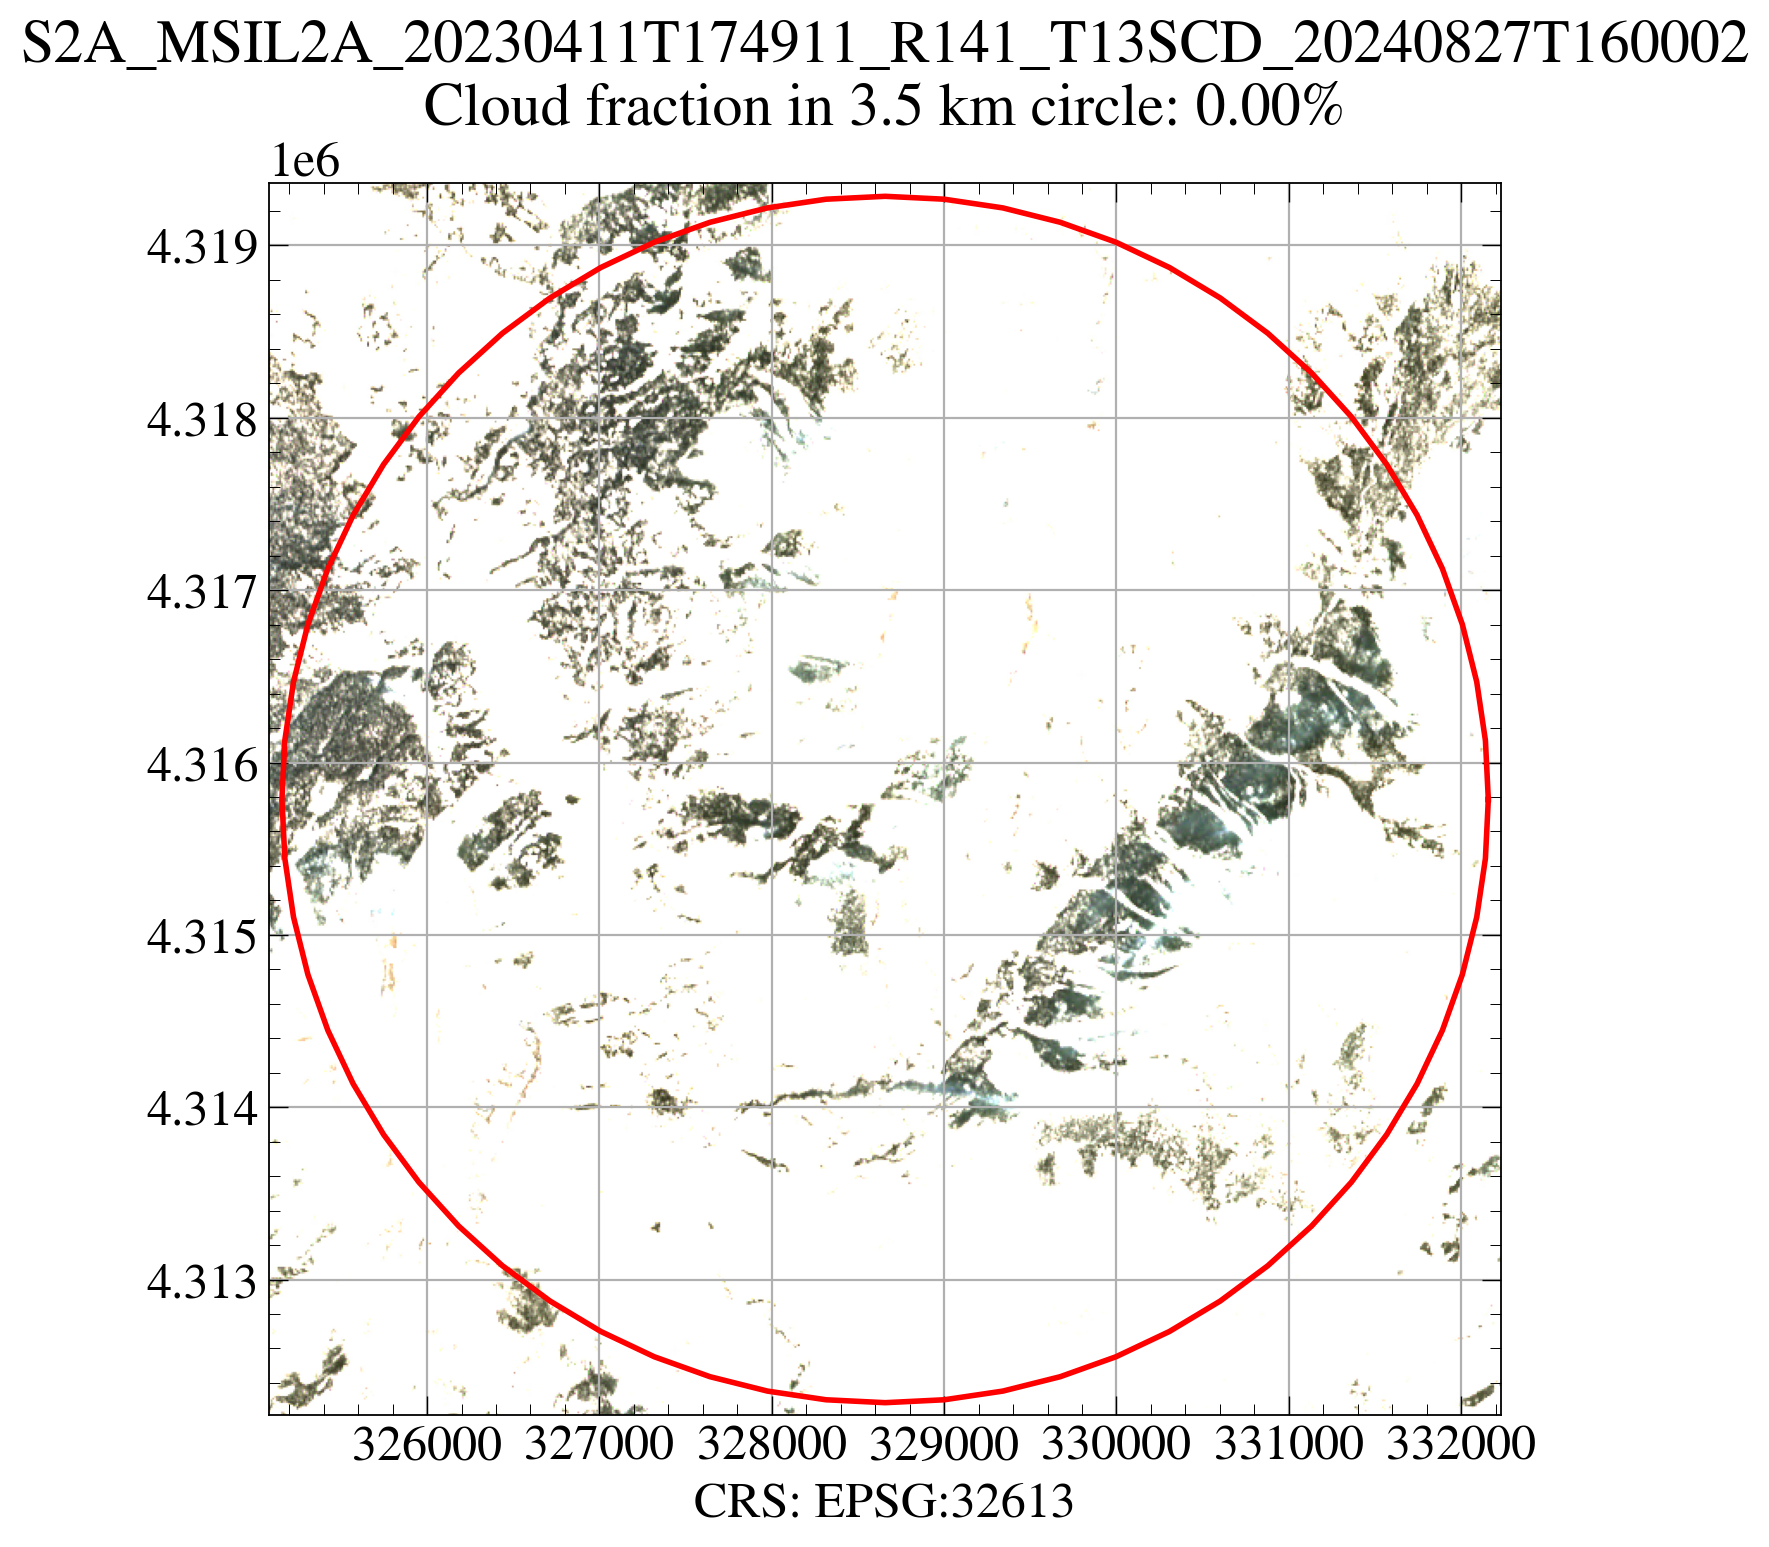

In [22]:
# --- 3.5 km circle at AOI center + cloud fraction inside it (fixed 'boundless') ---
# Center of AOI bbox (WGS84)
minx, miny, maxx, maxy = AOI_BOUNDS_LL
center_lon = (minx + maxx) / 2.0
center_lat = (miny + maxy) / 2.0

# Build a 3.5 km circle in UTM 13N and bring back to WGS84
utm_epsg = "EPSG:32613"
to_utm = Transformer.from_crs("EPSG:4326", utm_epsg, always_xy=True).transform
to_wgs = Transformer.from_crs(utm_epsg, "EPSG:4326", always_xy=True).transform

pt_wgs = Point(center_lon, center_lat)
pt_utm = shp_transform(to_utm, pt_wgs)
circle_utm = pt_utm.buffer(3500.0)  # radius = 3.5 km
circle_wgs = shp_transform(to_wgs, circle_utm)

# 3) Compute cloud fraction inside the circle using the SCL asset
scl_href = planetary_computer.sign(least_cloudy_item.assets["SCL"].href)
with rasterio.open(scl_href) as scl_ds:
    # Window covering the circle (no 'boundless' here)
    circ_bounds_ll = circle_wgs.bounds  # (minx, miny, maxx, maxy) in WGS84
    circ_bounds_scl = warp.transform_bounds("EPSG:4326", scl_ds.crs, *circ_bounds_ll)
    scl_window = windows.from_bounds(*circ_bounds_scl, transform=scl_ds.transform)
    scl_win_transform = windows.transform(scl_window, scl_ds.transform)

    # Read with boundless=True so off-image areas are filled with a value we can mask out
    scl_arr = scl_ds.read(1, window=scl_window, masked=True, boundless=True, fill_value=0)

    # Rasterize the circle into SCL window grid
    circle_scl_crs = shp_transform(
        Transformer.from_crs("EPSG:4326", scl_ds.crs, always_xy=True).transform,
        circle_wgs
    )
    circle_mask = features.rasterize(
        [(mapping(circle_scl_crs), 1)],
        out_shape=scl_arr.shape,
        transform=scl_win_transform,
        fill=0,
        dtype="uint8",
        all_touched=False,
    ).astype(bool)

    # Define "cloud" pixels: SCL in {8, 9, 10} (clouds + cirrus)
    # (If you want to include cloud shadows, add 3 to this list.)
    cloud_classes = np.array([3, 8, 9, 10], dtype=np.uint8)

    # Valid = inside circle & not masked & not fill_value(=0) & SCL in 1..11
    valid_inside = circle_mask & (~scl_arr.mask) & (scl_arr.data != 0)
    clouds_inside = valid_inside & np.isin(scl_arr.data.astype(np.uint8), cloud_classes)

    num_valid = int(valid_inside.sum())
    num_cloud = int(clouds_inside.sum())
    cloud_fraction = (num_cloud / num_valid) if num_valid > 0 else np.nan

print(f"Circle center (lon, lat): ({center_lon:.6f}, {center_lat:.6f})")
print(f"Cloud cover inside 3.5 km circle: "
      f"{'NaN' if np.isnan(cloud_fraction) else f'{cloud_fraction:.3%}'}  "
      f"(cloud pixels {num_cloud} / valid pixels {num_valid})")

# 4) Plot the visual image window with the circle overlaid
visual_href = planetary_computer.sign(least_cloudy_item.assets["visual"].href)
with rasterio.open(visual_href) as vds:
    circ_bounds_vis = warp.transform_bounds("EPSG:4326", vds.crs, *circ_bounds_ll)
    vis_window = windows.from_bounds(*circ_bounds_vis, transform=vds.transform)
    vis_transform = windows.transform(vis_window, vds.transform)

    # Read visual with boundless=True
    vis_img = vds.read(window=vis_window, boundless=True, fill_value=0)

    # Prepare RGB for plotting
    if vis_img.shape[0] >= 3:
        rgb = np.moveaxis(vis_img[:3], 0, -1).astype("float32")
        if rgb.max() > 1.0:
            rgb /= 255.0
    else:
        rgb = np.moveaxis(vis_img, 0, -1).astype("float32")
        if rgb.max() > 1.0:
            rgb /= 255.0

    # Transform circle to the visual CRS for overlay
    circle_vis_crs = shp_transform(
        Transformer.from_crs("EPSG:4326", vds.crs, always_xy=True).transform,
        circle_wgs
    )
    cx, cy = circle_vis_crs.exterior.xy

    # Plot
    left, bottom, right, top = rasterio.windows.bounds(vis_window, vds.transform)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(rgb, extent=[left, right, bottom, top], origin="upper")
    ax.plot(cx, cy, linewidth=2, color="red")
    ax.set_title(f"{least_cloudy_item.id}\nCloud fraction in 3.5 km circle: "
                 f"{'NaN' if np.isnan(cloud_fraction) else f'{cloud_fraction:.2%}'}")
    ax.set_xlabel(f"CRS: {vds.crs}")
    ax.set_ylabel("")
    plt.show()

# Quick sanity check
assert (np.isnan(cloud_fraction) or (0.0 <= cloud_fraction <= 1.0)), "Cloud fraction out of range."


## Render our AOI from this image

In [23]:
with rasterio.open(asset_href) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

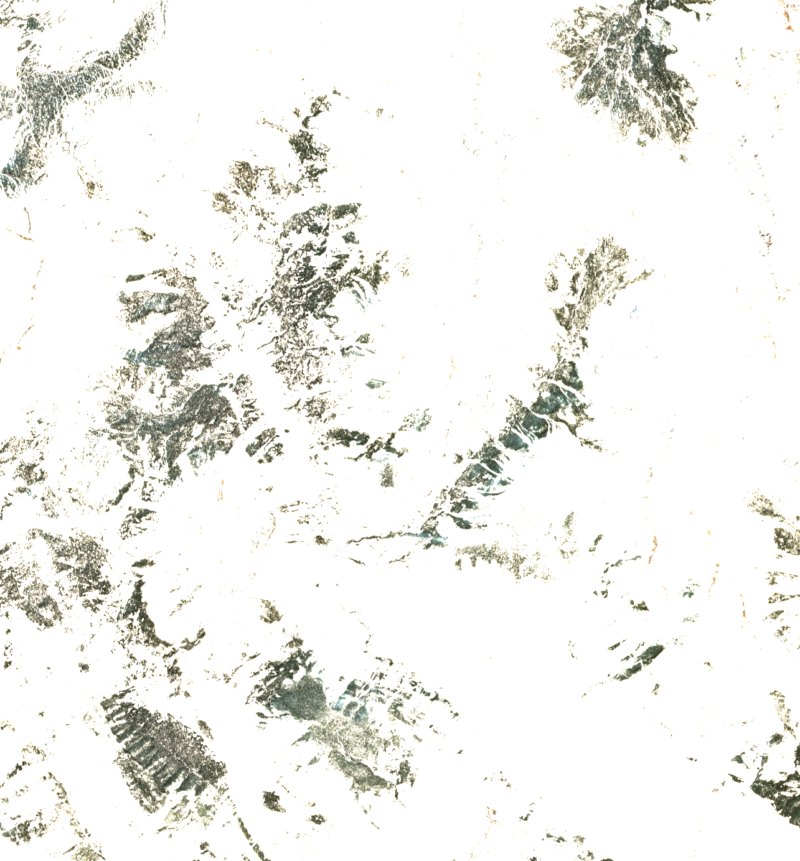

In [24]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.Resampling.BILINEAR)

# The End